In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
# transforms
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

In [3]:
# datasets
trainset = torchvision.datasets.FashionMNIST('/home/kevinxu95/Data',
            download=True, train=True, transform=transform)

testset = torchvision.datasets.FashionMNIST('/home/kevinxu95/Data', 
            download=True, train=False, transform = transform)

In [4]:
# dataloaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, 
                                         shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=True, num_workers=2)

In [5]:
# class labels
classes = ('T-shirt/tio', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sanal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

In [6]:
# helper function to show an image
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5  # unnormalise
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [7]:
# model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    

net = Net()

In [8]:
# hyperparameters
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# 1. Tensorboard setup

In [9]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/fashion_mnist_experiment_1')

# 2. Write to Tensorboard

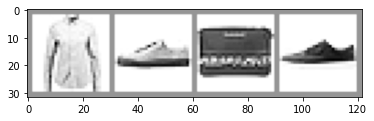

In [10]:
# get random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# create grid of images
img_grid = torchvision.utils.make_grid(images)

# show images
matplotlib_imshow(img_grid, one_channel=True)

# write to Tensorboard
writer.add_image('four_fashion_mnist_images', img_grid)

In [11]:
# ! tensorboard --logdir=runs

# 3. Inspect the model

In [12]:
writer.add_graph(net, images)
writer.close()

# 4. Add a projector
We can visualize the lower dimensional representation of higher dimensional data via the add_embedding method.

In [13]:
# select n random points with labels
def select_n_random(data, labels, n=100):
    
    assert len(data) == len(labels)
    
    perm = torch.randperm(len(data))
    return data[perm][:n], labels[perm][:n]

# select random images and their target indices
images, labels = select_n_random(trainset.data, trainset.targets)

# get the class labels for each image
class_labels = [classes[lab] for lab in labels]

# log embeddings
features = images.view(-1, 28 * 28)
writer.add_embedding(features, metadata=class_labels, 
                     label_img=images.unsqueeze(1))
writer.close()    

# 5. Track model training

In [14]:
# generate predictions and corresponding probabilities
def images_to_probs(net, images):
    
    output = net(images)
    
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]

In [15]:
# generate matplotlib figure of top prediction
def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)
    
    # plot the images in the batch
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [16]:
# train the model and log the process
running_loss = 0.0
for epoch in range(1):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data  # [inputs, labels]
        optimizer.zero_grad()  # zero th parameter gradients

        outputs = net(inputs)  # forward
        loss = criterion(outputs, labels)
        loss.backward()  # backward
        optimizer.step()  # optimise
        
        running_loss += loss.item()
        if i % 1000 == 999:  # every 1000 mini batches
            # log running loss
            writer.add_scalar('training loss', 
                             running_loss / 1000, 
                             epoch * len(trainloader) + i)
            # log figure of predictions
            writer.add_figure('predictions vs actuals',
                             plot_classes_preds(net, inputs, labels),
                             global_step=epoch * len(trainloader) + i)
            running_loss = 0.0

print('Finished Training')

Finished Training


# 6. Assess trained models

In [17]:
# get the probability and predictions
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)
        
        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)
        
test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

In [18]:
# plot classes with corresponding precision-recall curve
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]
    
    writer.add_pr_curve(classes[class_index],
                       tensorboard_preds,
                       tensorboard_probs,
                       global_step=global_step)
    writer.close()

In [19]:
# plot all the pr curves
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)